In [9]:
setwd('/import/hd//sc')

In [10]:
library(CARD)
library(MuSiC)
library(TOAST)
library(Seurat)
library(patchwork)
library(tidyverse)

In [11]:
OA7  =readRDS('../mye.OA7.rds')
spatial_count <-  OA7@assays$Spatial@counts
spatial_loca <- OA7@images$slice1@coordinates

In [12]:
spatial_location <- spatial_loca[,2:3]
colnames(spatial_location) <- c("x","y")

In [13]:
sc = readRDS('./sce2.merged.macro.rds')
table(sc$celltype)


Inflamm.Macro     Resid.mac      SPP1_mac 
         2285          3115           159 

In [14]:
#  sc
sc_count <- sc@assays$RNA@counts
sc_count[1:4,1:4]

sc_meta <- sc@meta.data %>% 
  rownames_to_column("cellID") %>%
  dplyr::select(cellID,orig.ident,celltype) %>% 
  mutate(CB = cellID) %>% 
  column_to_rownames("CB")

4 x 4 sparse Matrix of class "dgCMatrix"
           AAACCCAAGTCCCGGT-1_1 AAACGCTAGGAGTACC-1_1 AAAGAACGTAAGCTCT-1_1
AL627309.1                    .                    .                    .
AL627309.5                    .                    .                    .
LINC01409                     .                    .                    .
FAM87B                        .                    .                    .
           AAAGGGCAGGACAGCT-1_1
AL627309.1                    .
AL627309.5                    .
LINC01409                     .
FAM87B                        .

In [15]:
CARD_obj = createCARDObject( 
  sc_count = sc_count, 
  sc_meta = sc_meta, 
  spatial_count = spatial_count, 
  spatial_location = spatial_location, 
  ct.varname = "celltype", 
  ct.select = unique(sc_meta$celltype), #细胞类型列名
  sample.varname = "orig.ident", 
  minCountGene = 100, 
  minCountSpot = 5)  

## QC on scRNASeq dataset! ...
## QC on spatially-resolved dataset! ...


## create reference matrix from scRNASeq...
## Select Informative Genes! ...
## Deconvolution Starts! ...
## Deconvolution Finish! ...
                   Resid.mac Inflamm.Macro  SPP1_mac
AACACTTGGCAAGGAA-1 0.6061261     0.2293809 0.1644930
AACAGTCAGGCTCCGC-1 0.4949861     0.2605096 0.2445043
AACAGTCCACGCGGTG-1 0.4690598     0.3216245 0.2093157
AACATCTTAAGGCTCA-1 0.3233149     0.5148414 0.1618437
AACCAAGCGTGGCCTC-1 0.2523878     0.4686593 0.2789529
AACCAAGGTATCAGGC-1 0.2468955     0.4051150 0.3479895


Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.


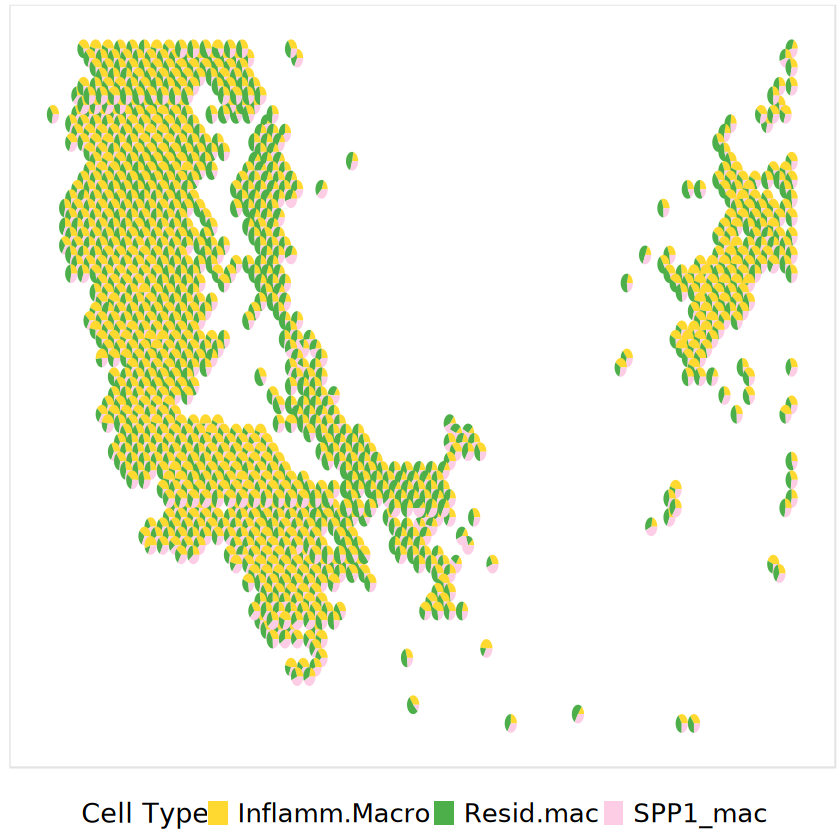

In [16]:
CARD_obj = CARD_deconvolution(CARD_object = CARD_obj)
print(CARD_obj@Proportion_CARD[1:6,])

# colors =  c("#000000", "#E69F00", "red", "#009E73", "#F0E442", "#0072B2",
#             "#D55E00", "#CC79A7")
colors = c("#FFD92F","#4DAF4A","#FCCDE5","#D9D9D9","#377EB8","#7FC97F","#BEAED4",
           "#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D")

p1 <- CARD.visualize.pie(proportion = CARD_obj@Proportion_CARD,radius  = 1,
                         spatial_location = CARD_obj@spatial_location, 
                         colors = colors)+coord_flip()#+ scale_x_reverse()
p1+scale_x_reverse()+coord_flip()+scale_y_reverse()+guides(color = guide_legend(override.aes = list(size = 5)))

In [20]:
options(repr.plot.width = 15)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


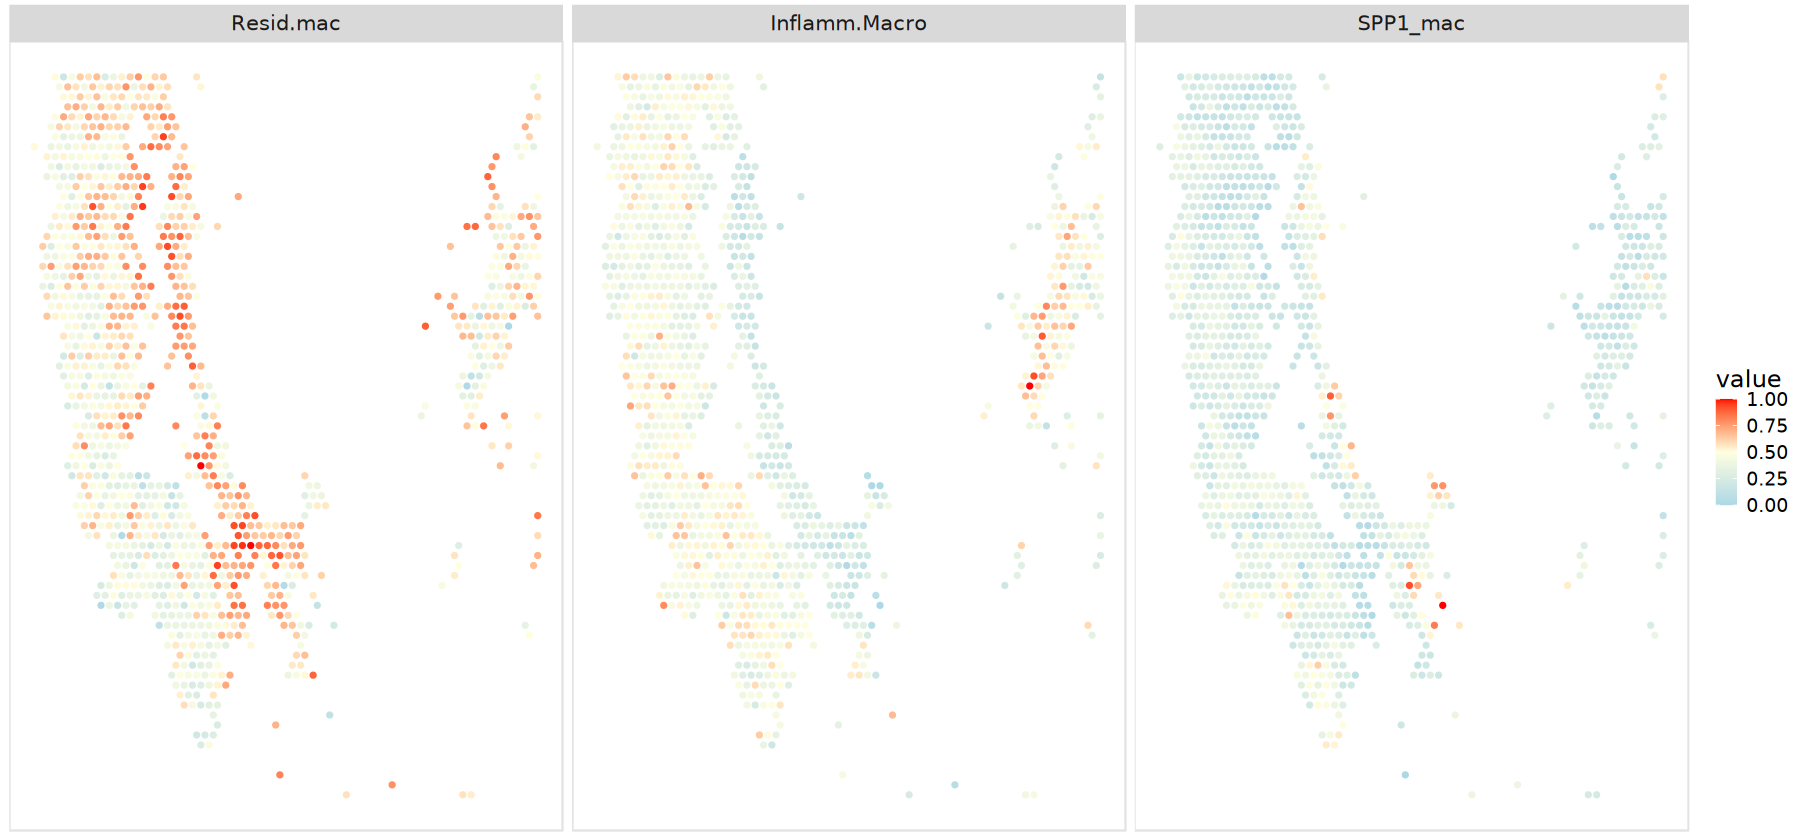

In [21]:
ct.visualize = unique(sc$celltype)
## visualize the spatial distribution of the cell type proportion
p2 <- CARD.visualize.prop(
  proportion = CARD_obj@Proportion_CARD,     pointSize = 1,   
  spatial_location = CARD_obj@spatial_location, 
  ct.visualize = ct.visualize,                 ### selected cell types to visualize
  colors = c("lightblue","lightyellow","red"), ### if not provide, we will use the default colors
  NumCols = 3)    +coord_flip()   +scale_y_reverse()  +scale_x_reverse()                        ### number of columns in the figure panel
print(p2)

In [24]:
options(repr.plot.width = 7,repr.plot.height = 7)

Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Coordinate system already present. Adding new coordinate system, which will
replace the existing one.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


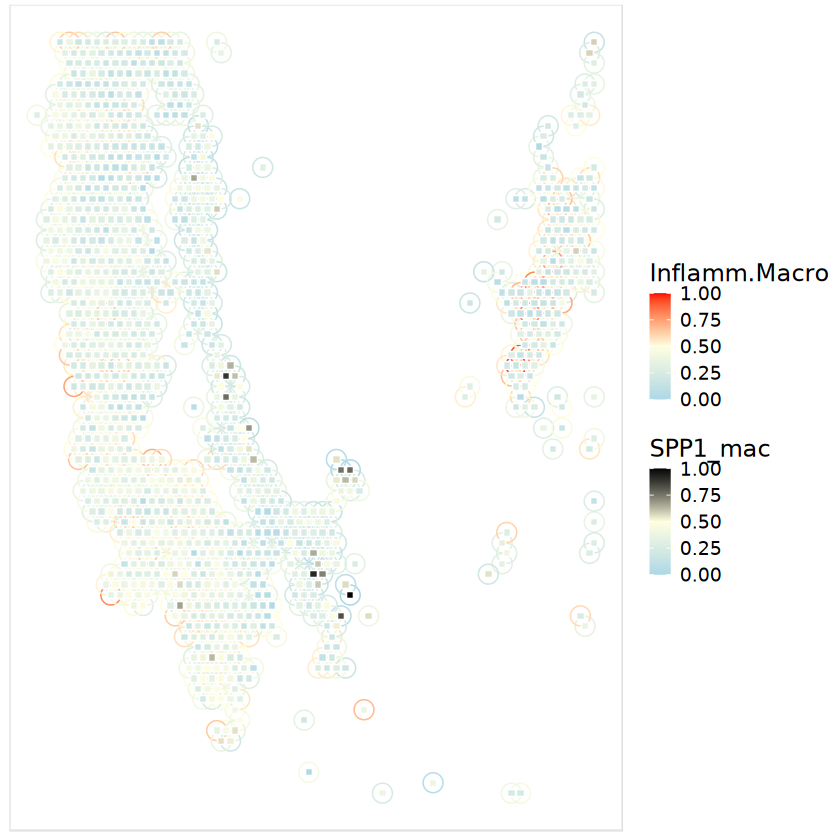

In [25]:
p3 = CARD.visualize.prop.2CT(
  proportion = CARD_obj@Proportion_CARD,                             ### Cell type proportion estimated by CARD
  spatial_location = CARD_obj@spatial_location,                  ### two cell types you want to visualize
  ct2.visualize = c("Inflamm.Macro","SPP1_mac"),
  colors = list(c("lightblue","lightyellow","red"),c("lightblue","lightyellow","black"))) +coord_flip()      ### two color scales                             
p3+coord_flip()   +scale_y_reverse()  +scale_x_reverse()   
ggsave('figure3-OA7-sub.pdf',width = 8,height = 6)

In [ ]:





p4 <- CARD.visualize.Cor(CARD_obj@Proportion_CARD,colors = NULL) +coord_flip()# if not provide, we will use the default colors
p4
ggsave('figure4-OA7-sub.pdf',width = 8,height = 6)

CARD_obj = CARD.imputation(CARD_obj,NumGrids = 2000,ineibor = 10,exclude = NULL)


## Visualize the newly grided spatial locations to see if the shape is correctly detected. If not, the user can provide the row names of the excluded spatial location data into the CARD.imputation function
location_imputation = cbind.data.frame(x=as.numeric(sapply(strsplit(rownames(CARD_obj@refined_prop),split="x"),"[",1)),
                                       y=as.numeric(sapply(strsplit(rownames(CARD_obj@refined_prop),split="x"),"[",2)))
rownames(location_imputation) = rownames(CARD_obj@refined_prop)
library(ggplot2)
ggplot(location_imputation, 
       aes(x = x, y = y)) + geom_point(shape=22,color = "#7dc7f5")+
  theme(plot.margin = margin(0.1, 0.1, 0.1, 0.1, "cm"),
        legend.position="bottom",
        panel.background = element_blank(),
        plot.background = element_blank(),
        panel.border = element_rect(colour = "grey89", fill=NA, size=0.5))+coord_flip() +scale_y_reverse()  +scale_x_reverse()    #
#ggsave(file="newly_grid-OA7-sub.pdf",width=14,height=14)

CARD.visualize.prop(
  proportion = CARD_obj@refined_prop,                         
  spatial_location = location_imputation,            
  ct.visualize = ct.visualize,                    
  colors = c("lightblue","lightyellow","red"),    
  NumCols = 4)    +coord_flip()   +scale_y_reverse() +scale_x_reverse()   
#ggsave(file="enhanced_resolution_proportion-OA7-sub.pdf",width=18,height=18)

# ,'CD68','MS4A6A','CD163','CD14','MRC1','PECAM1','CDH5','VWF','FLT1'

CARD.visualize.gene(
  spatial_expression = CARD_obj@refined_expression,
  spatial_location = location_imputation,
  gene.visualize = c("CD163"),
  colors = NULL,
  NumCols = 3)+coord_flip() +scale_y_reverse() +scale_x_reverse()   


## METHOD2 Create an CARDfree object

load('./hd2/sc/my_list_no_na2.rda')
markerList = my_list_no_na
spatial_count <-  OA7@assays$Spatial@counts
spatial_loca <- OA7@images$slice1@coordinates

spatial_location <- spatial_loca[,2:3]
colnames(spatial_location) <- c("x","y")

## CARDfree
CARDfree_obj = createCARDfreeObject(
  markerList = markerList,
  spatial_count = spatial_count,
  spatial_location = spatial_location,
  minCountGene = 100,
  minCountSpot =5) ###创建CARDfree对象
CARDfree_obj = CARD_refFree(CARDfree_obj)

colors = c("#FFD92F","#4DAF4A","#FCCDE5","#D9D9D9","#377EB8","#7FC97F","#BEAED4",
           "#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D")

CARDfree_obj@Proportion_CARD

CARDfree_obj@Proportion_CARD = CARDfree_obj@Proportion_CARD[,c(1:16)]
colnames(CARDfree_obj@Proportion_CARD) = paste0("CT",1:16)
p1 <- CARD.visualize.pie(CARDfree_obj@Proportion_CARD,CARDfree_obj@spatial_location,colors = colors)
p1+coord_flip()   +scale_y_reverse() +scale_x_reverse() 


ggsave(file="OA7-CT-sub.pdf",width=18,height=18)








# scmapping

scMapping = CARD_SCMapping(CARD_obj,shapeSpot="Square",numCell=20,ncore=40)
print(scMapping)
### spatial location info and expression count of the single cell resolution data
library(SingleCellExperiment)
MapCellCords = as.data.frame(colData(scMapping))
count_SC = assays(scMapping)$counts



df = MapCellCords
colors = c("#FFD92F","#4DAF4A","#FCCDE5","#D9D9D9","#377EB8","#7FC97F","#BEAED4",
           "#FDC086","#FFFF99","#386CB0","#F0027F","#BF5B17","#666666","#1B9E77","#D95F02",
           "#7570B3","#E7298A","#66A61E","#E6AB02","#A6761D")
p2 = ggplot(df, aes(x = x, y = y, colour = CT)) + 
  geom_point(size = 0.1) +
  scale_colour_manual(values =  colors) +
  #facet_wrap(~Method,ncol = 2,nrow = 3) + 
  theme(plot.margin = margin(0.1, 0.1, 0.1, 0.1, "cm"),
        panel.background = element_rect(colour = "white", fill="white"),
        plot.background = element_rect(colour = "white", fill="white"),
        legend.position="bottom",
        panel.border = element_rect(colour = "grey89", fill=NA, size=0.5),
        axis.text =element_blank(),
        axis.ticks =element_blank(),
        axis.title =element_blank(),
        legend.title=element_text(size = 13,face="bold"),
        legend.text=element_text(size = 12),
        legend.key = element_rect(colour = "transparent", fill = "white"),
        legend.key.size = unit(.5, 'cm'),
        strip.text = element_text(size = 1.55,face="bold"))+
  guides(color=guide_legend(title="Cell Type"))
p2+scale_x_reverse()+coord_flip()+scale_y_reverse()+guides(color = guide_legend(override.aes = list(size = 5)))

ggsave('mapping-OA7-sub.pdf',width = 6,height = 6)http://seu-nmee.com:8786/graphics/6f9ac3ac-2212-4aad-ba74-c7c4f21dfcee.png



# 只展示fib 和m
colors =  c("grey", "grey", "red", "grey", "#F0E442", "#0072B2",
            "grey", "grey")
p2 = ggplot(df, aes(x = x, y = y, colour = CT)) + 
  geom_point(size = 0.1) +
  scale_colour_manual(values =  colors) +
  #facet_wrap(~Method,ncol = 2,nrow = 3) + 
  theme(plot.margin = margin(0.1, 0.1, 0.1, 0.1, "cm"),
        panel.background = element_rect(colour = "white", fill="white"),
        plot.background = element_rect(colour = "white", fill="white"),
        legend.position="bottom",
        panel.border = element_rect(colour = "grey89", fill=NA, size=0.5),
        axis.text =element_blank(),
        axis.ticks =element_blank(),
        axis.title =element_blank(),
        legend.title=element_text(size = 13,face="bold"),
        legend.text=element_text(size = 12),
        legend.key = element_rect(colour = "transparent", fill = "white"),
        legend.key.size = unit(.5, 'cm'),
        strip.text = element_text(size = 1.55,face="bold"))+
  guides(color=guide_legend(title="Cell Type"))
p2+scale_x_reverse()+coord_flip()+scale_y_reverse()+guides(color = guide_legend(override.aes = list(size = 5)))

ggsave('mapping-OA7-Endo-Mye.pdf',width = 6,height = 6)























